# 导入库

In [223]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
from collections import deque
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
from torch.optim import lr_scheduler


# 加载数据

In [224]:
# 1. 加载和预处理数据
data = pd.read_csv('D:\helloworld\VT1\data\keypoints2.csv')
X = data.drop('label', axis=1).values
y = data['label'].values


In [225]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [226]:
X

array([[0.93388152, 0.78938367, 0.92981653, ..., 0.9276406 , 0.58331999,
        0.88718399],
       [0.94525129, 0.79481047, 0.94289053, ..., 0.92345961, 0.58209952,
        0.8807991 ],
       [0.95304569, 0.79293109, 0.94833042, ..., 0.92306028, 0.58154152,
        0.88030847],
       ...,
       [0.01078312, 0.26391562, 0.17474516, ..., 0.5414239 , 0.40837272,
        0.49730566],
       [0.00619659, 0.26097199, 0.16970664, ..., 0.54589843, 0.40690443,
        0.5004999 ],
       [0.06663486, 0.31096485, 0.20290592, ..., 0.54300267, 0.40485625,
        0.50085526]])

In [227]:
# 标签编码
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [228]:
# 设置每个序列的长度
seq_length = 4
batch_size = 128

In [229]:
# num_samples, seq_length, num_features

num_samples = len(X) // seq_length
num_features = X.shape[1]
X_reshaped = X[:num_samples * seq_length].reshape((num_samples, seq_length, num_features))


In [230]:
X_reshaped

array([[[0.93388152, 0.78938367, 0.92981653, ..., 0.9276406 ,
         0.58331999, 0.88718399],
        [0.94525129, 0.79481047, 0.94289053, ..., 0.92345961,
         0.58209952, 0.8807991 ],
        [0.95304569, 0.79293109, 0.94833042, ..., 0.92306028,
         0.58154152, 0.88030847],
        [0.94493625, 0.78899772, 0.93902299, ..., 0.92479992,
         0.58232971, 0.88276847]],

       [[0.1876214 , 0.77398932, 0.21373266, ..., 0.93578848,
         0.4266105 , 0.8847608 ],
        [0.94662799, 0.79515533, 0.94476706, ..., 0.92242546,
         0.58077156, 0.8775228 ],
        [0.956487  , 0.7898505 , 0.94937662, ..., 0.92531794,
         0.58112631, 0.88145443],
        [0.93771539, 0.79261599, 0.93440703, ..., 0.93142226,
         0.58285598, 0.88830723]],

       [[0.1830829 , 0.77786612, 0.20763806, ..., 0.93160326,
         0.42841506, 0.87932872],
        [1.        , 0.77010348, 0.98807018, ..., 0.92876396,
         0.59819134, 0.89551123],
        [0.96087731, 0.788718  , 0.9

In [231]:
y_reshaped = y[:num_samples * seq_length:seq_length]


# 划分训练集和测试集


In [232]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)


In [233]:
# 转换数据为 PyTorch 张量
# 使用 dtype=torch.float32 明确指定数据类型为 float32
X_train = torch.tensor(X_train, dtype=torch.float32)  # 训练数据
y_train = torch.tensor(y_train, dtype=torch.long)     # 训练标签
X_test = torch.tensor(X_test, dtype=torch.float32)    # 测试数据
y_test = torch.tensor(y_test, dtype=torch.long)       # 测试标签


In [234]:
# 将数据转换为 PyTorch 张量
X_train_tensor = torch.as_tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)
X_test_tensor = torch.as_tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)


In [235]:
# 创建 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [236]:
# 创建 DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 检查

In [237]:
y_min = y.min()
y_max = y.max()



In [238]:
X_train_shape = X_train.shape
y_train_shape = y_train.shape
X_test_shape = X_test.shape
y_test_shape = y_test.shape

# 3. 检查是否有 NaN 或 Inf 的值
# 检查X中是否有NaN或Inf值
has_nan_X = torch.isnan(X_train).any() or torch.isnan(X_test).any()
has_inf_X = torch.isinf(X_train).any() or torch.isinf(X_test).any()

y_min, y_max, X_train_shape, y_train_shape, X_test_shape, y_test_shape, has_nan_X, has_inf_X

(0,
 9,
 torch.Size([1519, 4, 42]),
 torch.Size([1519]),
 torch.Size([380, 4, 42]),
 torch.Size([380]),
 tensor(False),
 tensor(False))

In [239]:
print("Min label:", y.min())
print("Max label:", y.max())


Min label: 0
Max label: 9


In [240]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: torch.Size([1519, 4, 42])
y_train shape: torch.Size([1519])
X_test shape: torch.Size([380, 4, 42])
y_test shape: torch.Size([380])


In [241]:
print("Has NaN in X_train:", torch.isnan(X_train).any().item())
print("Has Inf in X_train:", torch.isinf(X_train).any().item())
print("Has NaN in X_test:", torch.isnan(X_test).any().item())
print("Has Inf in X_test:", torch.isinf(X_test).any().item())


Has NaN in X_train: False
Has Inf in X_train: False
Has NaN in X_test: False
Has Inf in X_test: False


# model

In [242]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [218]:
class SelfAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead=8):
        super(SelfAttentionModel, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)
        self.self_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=nhead)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        out, _ = self.self_attention(x, x, x)
        out = out.permute(1, 0, 2)
        out = self.fc(out[:, -1, :])
        return out


# 从零实现

In [243]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_prob=0.5):
        super(MultiheadAttention, self).__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads  # 多头注意力的头数
        self.head_dim = embed_dim // num_heads  # 每个头的维度
        self.scale = self.head_dim ** 0.5  # 缩放因子

        self.query = nn.Linear(embed_dim, embed_dim)  # 查询矩阵变换 Q
        self.key = nn.Linear(embed_dim, embed_dim)  # 键矩阵变换 K
        self.value = nn.Linear(embed_dim, embed_dim)  # 值矩阵变换 V
        self.fc_out = nn.Linear(embed_dim, embed_dim)  # 输出全连接层 FC

        self.dropout = nn.Dropout(dropout_prob)  # Dropout层
        
        self._initialize_weights()  # 权重初始化

    def _initialize_weights(self):
        # 初始化权重
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, query, key, value):
        # 前向传播
        batch_size = query.size(0)
        
        query = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        key = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        value = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Scaled Dot-Product Attention
        attention = torch.matmul(query, key.permute(0, 1, 3, 2)) / self.scale
        attention = F.softmax(attention, dim=-1)
        output = torch.matmul(self.dropout(attention), value)
        
        # 重组并通过输出全连接层
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        output = self.fc_out(output)
        
        # 残差连接
        return output + query.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)


In [244]:
class SelfAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead=8, dropout_prob=0.5):
        super(SelfAttentionModel, self).__init__()
        self.hidden_size = hidden_size  # 隐藏层大小 hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)  # 嵌入层 embedding
        self.self_attention = MultiheadAttention(embed_dim=hidden_size, num_heads=nhead, dropout_prob=dropout_prob)  # 多头自注意力层 MultiheadAttention
        self.layer_norm1 = nn.LayerNorm(hidden_size)  # 层归一化 layer norm
        self.fc1 = nn.Linear(hidden_size, 4 * hidden_size)  # Feed Forward 1
        self.fc2 = nn.Linear(4 * hidden_size, hidden_size)  # Feed Forward 2
        self.relu = nn.ReLU()  # 激活函数
        self.layer_norm2 = nn.LayerNorm(hidden_size)  # 层归一化 layer norm
        self.fc_out = nn.Linear(hidden_size, output_size)  # 输出全连接层 FC
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout层
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout层
        
        self._initialize_weights()  # 权重初始化

    def _initialize_weights(self):
        # 初始化权重
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # 前向传播
        x = self.embedding(x)  # 通过嵌入层
        #x = x.permute(1, 0, 2)  # 交换维度
        
        # 多头自注意力层
        att_output = self.self_attention(x, x, x)
        out = self.layer_norm1(x + self.dropout1(att_output))  # 加上残差连接并进行层归一化
        
        # Feed Forward部分
        ff_input = out[:, -1, :]
        ff_output = self.fc2(self.relu(self.fc1(ff_input)))
        out = self.layer_norm2(out + self.dropout2(ff_output.unsqueeze(1)))  # 加上残差连接并进行层归一化
        
        # 输出全连接层
        out = self.fc_out(out[:, -1, :])
        return out


In [245]:
input_size =  X_train.shape[2]
hidden_size = 256
output_size = len(set(y)) 
model = SelfAttentionModel(input_size, hidden_size, output_size).to(device)



In [246]:
# 打印数据形状和模型结构以检查代码
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("Model structure:", model)

X_train_tensor shape: torch.Size([1519, 4, 42])
y_train_tensor shape: torch.Size([1519])
Model structure: SelfAttentionModel(
  (embedding): Linear(in_features=42, out_features=256, bias=True)
  (self_attention): MultiheadAttention(
    (query): Linear(in_features=256, out_features=256, bias=True)
    (key): Linear(in_features=256, out_features=256, bias=True)
    (value): Linear(in_features=256, out_features=256, bias=True)
    (fc_out): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


# train

In [247]:
def calculate_mean_std(train_loader):
    all_data = []
    for batch_X, _ in train_loader:
        all_data.append(batch_X)
    all_data = torch.cat(all_data, dim=0)
    mean = torch.mean(all_data, dim=0)
    std = torch.std(all_data, dim=0)
    return mean, std

def normalize_data(data, mean, std):
    return (data - mean) / (std + 1e-7)

# 这里假设 train_loader 是一个 DataLoader 实例用于加载训练数据
mean, std = calculate_mean_std(train_loader)


In [248]:
# 初始化数据列表，用于存储训练损失、验证损失和准确率
train_losses = []
validation_losses = []
accuracies = []

# 设置训练的轮数
epochs = 300

# 早停参数
patience = 300
best_val_loss = float('inf')  
early_stopping_counter = 0

# 定义模型、损失函数和优化器
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

# 开始训练
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            validation_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == batch_y).sum().item()
            total_predictions += batch_y.size(0)
    
    validation_losses.append(validation_loss / len(test_loader))
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

    print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    # 更新学习率调度器
    scheduler.step(validation_losses[-1])

    if validation_losses[-1] < best_val_loss:
        best_val_loss = validation_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early Stopping!")
            break


Epoch: 1/300, Train Loss: 2.8777, Validation Loss: 2.0643, Accuracy: 23.42%
Epoch: 2/300, Train Loss: 2.2590, Validation Loss: 1.6816, Accuracy: 46.58%
Epoch: 3/300, Train Loss: 1.6836, Validation Loss: 1.7457, Accuracy: 54.21%
Epoch: 4/300, Train Loss: 1.3417, Validation Loss: 1.3041, Accuracy: 61.32%
Epoch: 5/300, Train Loss: 1.1112, Validation Loss: 1.3104, Accuracy: 65.00%
Epoch: 6/300, Train Loss: 0.9843, Validation Loss: 1.2134, Accuracy: 66.05%
Epoch: 7/300, Train Loss: 0.8747, Validation Loss: 0.9799, Accuracy: 67.63%
Epoch: 8/300, Train Loss: 0.8013, Validation Loss: 1.0061, Accuracy: 70.26%
Epoch: 9/300, Train Loss: 0.7256, Validation Loss: 1.0462, Accuracy: 71.58%
Epoch: 10/300, Train Loss: 0.6836, Validation Loss: 0.8198, Accuracy: 75.53%
Epoch: 11/300, Train Loss: 0.6228, Validation Loss: 0.7317, Accuracy: 78.68%
Epoch: 12/300, Train Loss: 0.5804, Validation Loss: 0.7668, Accuracy: 75.79%
Epoch: 13/300, Train Loss: 0.5258, Validation Loss: 0.6405, Accuracy: 82.89%
Epoch: 1

torch.optim.lr_scheduler.ReduceLROnPlateau是用于调整学习率的调度器。

'min'意味着当被监视的数量停止下降时，学习率将减少。

patience=10是等待改进的轮数。例如，如果patience=10，那么在连续10个轮次中没有改进，学习率就会降低。

factor=0.5是减少学习率的因子。新的学习率将是旧学习率乘以这个因子。

verbose=True表示当学习率降低时，会打印一条消息。


In [26]:
eazy_train =train_losses
eazy_validation =validation_losses
eazy_accuracies =accuracies


In [119]:
train2 =train_losses
validation2 =validation_losses
accuracies2 =accuracies

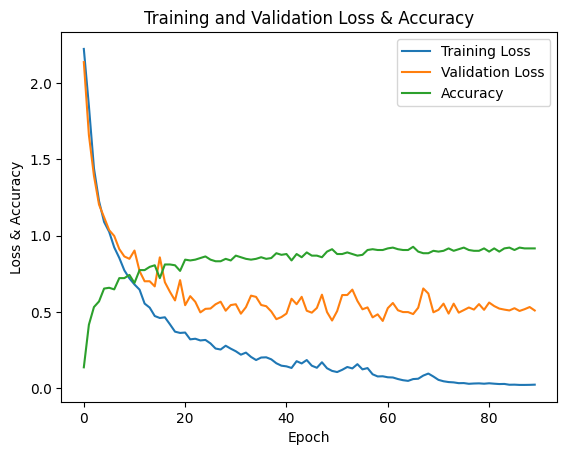

In [28]:
# 绘制曲线图
plt.figure()
plt.plot(eazy_train, label='Training Loss')

plt.plot(eazy_validation, label='Validation Loss')

plt.plot(eazy_accuracies, label='Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss & Accuracy')
plt.legend()
plt.show()

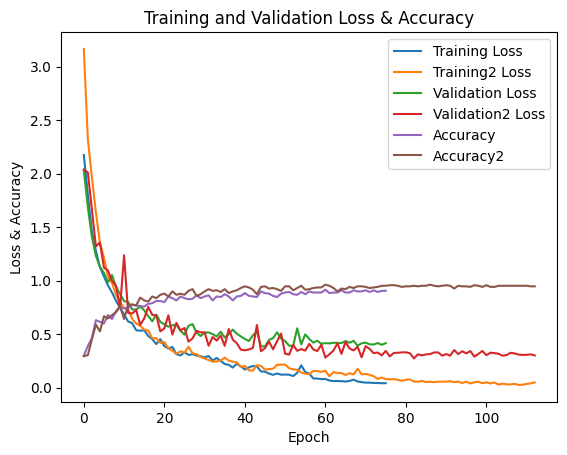

In [120]:
# 绘制曲线图
plt.figure()
plt.plot(eazy_train, label='Training Loss')
plt.plot(train2, label='Training2 Loss')
plt.plot(eazy_validation, label='Validation Loss')
plt.plot(validation2, label='Validation2 Loss')
plt.plot(eazy_accuracies, label='Accuracy')
plt.plot(accuracies2, label='Accuracy2')

plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss & Accuracy')
plt.legend()
plt.show()


In [121]:
torch.save(model.state_dict(), 'D:\helloworld\VT1\model_attention\model1.pth')
loaded_model = SelfAttentionModel(input_size, hidden_size, output_size).to(device)
loaded_model.load_state_dict(torch.load('D:\helloworld\VT1\model_attention\model1.pth'))
loaded_model.eval()

SelfAttentionModel(
  (embedding): Linear(in_features=42, out_features=256, bias=True)
  (self_attention): MultiheadAttention(
    (query): Linear(in_features=256, out_features=256, bias=True)
    (key): Linear(in_features=256, out_features=256, bias=True)
    (value): Linear(in_features=256, out_features=256, bias=True)
    (fc_out): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

# 视频

In [122]:
# 初始化 MediaPipe Hands API
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils


video_path = 'D:\\helloworld\\VT1\\test_video\\test.mp4'
output_path = 'D:\\helloworld\\VT1\\test_video\\test_val_attention2.mp4'

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

probabilities_per_frame = {}
max_gesture_per_frame = {}
frame_steps = []



In [124]:
# 初始化 MediaPipe Hands 模型
with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hand_model:
    frame_step = 0  # 初始化帧步数
    while cap.isOpened():  # 当视频文件可以正常打开时
        ret, frame = cap.read()  # 读取一帧
        if not ret:  # 如果读取失败，则退出循环
            break

        # 更新帧步数，并将其添加到列表中
        frame_step += 1
        frame_steps.append(frame_step)

        # 以下代码大部分与之前相同，除了将“second”替换为“frame_step”

        timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0  # 获取当前帧的时间戳（秒）
        second = math.floor(timestamp)  # 将时间戳向下取整，得到当前帧所在的秒数

        # 将帧的颜色空间从 BGR 转为 RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # 使用手部模型对图像进行处理
        result = hand_model.process(image)
        # 将图像的颜色空间转回 BGR，以便后续的显示和保存
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if result.multi_hand_landmarks:  # 如果在图像中检测到手部
            # 以下代码与之前相同，除了将“second”替换为“frame_step”

            landmarks = result.multi_hand_landmarks[0]  # 获取第一只检测到的手的标记点
            mp_drawing.draw_landmarks(frame, landmarks, mp_hands.HAND_CONNECTIONS)

            x, y = [], []
            for lm in landmarks.landmark:  # 遍历所有标记点
                x.append(lm.x)  # 保存标记点的 x 坐标
                y.append(lm.y)  # 保存标记点的 y 坐标

            points = np.asarray([x, y])
            min = points.min(axis=1, keepdims=True)
            max = points.max(axis=1, keepdims=True)
            normalized = np.stack((points - min) / (max - min), axis=1).flatten()

            keypoints = torch.tensor(normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
            with torch.no_grad():
                output = loaded_model(keypoints)
                probabilities = torch.softmax(output, dim=1)
                gesture = torch.argmax(probabilities, dim=1).item()

            confidence = probabilities.max().item()

            if frame_step not in max_gesture_per_frame or confidence > max_gesture_per_frame[frame_step][1]:
                max_gesture_per_frame[frame_step] = (gesture, confidence)

            # 使用 LabelEncoder 的 inverse_transform 方法将预测的标签编码转换回原始标签
            gesture_name = label_encoder.inverse_transform([gesture])[0]
            cv2.putText(frame, f'Gesture: {gesture_name}, Confidence: {confidence:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # 获取所有的类别名
            class_names = label_encoder.classes_

            # 定义起始位置
            start_x = 10
            start_y = 50

            # 遍历所有的类别名和对应的概率
            for i, (class_name, prob) in enumerate(zip(class_names, probabilities.squeeze().tolist())):
                color = (0, 255, 0)  # 默认为绿色
                if prob > 0.1:
                    color = (0, 0, 255)  # 红色
                text = f'{class_name}: {prob:.2f}'  # 使用class_name，而不是gesture_name[i]
                cv2.putText(frame, text, (start_x, start_y + i*30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

                                
        out.write(frame)

cap.release()
out.release()